# Proof of Concept: Optimization of Pulse-Relax Flushing for Storage Recovery

**Objective:** Recover storage capacity in a clogged porous media by optimizing a **Pulse-Relax** injection schedule.  
**Method:** We use JAX to differentiate through the fluid dynamics solver, allowing us to automatically tune the **Pulse Frequency** and **Relaxation Ratio** to dissolve salt barriers.

## 1. Experimental Setup
* **Phase 1 (Damage):** Inject Supersaturated Brine to induce clogging.
* **Phase 2 (Optimization):** The Optimizer takes control, adjusting the Pulse-Relax waveform to remove the clog.
* **Metric:** Maximize Final Permeability (Flux) and Minimize Solid Salt Mass.

In [9]:
import jax
import jax.numpy as jnp
from jax import jit, grad, value_and_grad
import optax
import numpy as np
import matplotlib.pyplot as plt

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

# --- PHYSICS CONSTANTS ---
NX, NY = 120, 40       # Smaller domain for faster optimization loop
MAX_STEPS = 2000       # Simulation steps per iteration
TAU = 0.9
C_EQ = 0.35            # Solubility Limit
PRECIP_RATE = 0.05     # Clogging Speed
DISSOLVE_RATE = 0.1    # Cleaning Speed

# Lattice Constants (D2Q9)
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

print("JAX Environment Ready. Using Optax for optimization.")

JAX Environment Ready. Using Optax for optimization.


## 2. The Differentiable Physics Engine

We define the **Pulse-Relax** logic here. 
* **Pulse ($P_{high}$):** Forces fresh fluid into the pores.
* **Relax ($P_{low}$):** Lowers pressure to allow diffusion/backflow to clear the throat.

The optimizer will tune `frequency` and `duty_cycle`.

In [10]:
@jax.jit
def equilibrium(rho, u):
    u_sq = u[..., 0]**2 + u[..., 1]**2
    f_eq_list = []
    for i in range(9):
        cu = u[..., 0]*CX[i] + u[..., 1]*CY[i]
        term = 1 + 3*cu + 4.5*cu**2 - 1.5*u_sq
        f_eq_list.append(rho * W[i] * term)
    return jnp.stack(f_eq_list, axis=-1)

@jax.jit
def pulse_relax_policy(t, control_params):
    """
    Square-Wave Pressure Generator.
    control_params[0]: Frequency (How fast we switch)
    control_params[1]: Duty Cycle (Ratio of Pulse vs Relax)
    """
    freq = jnp.clip(control_params[0], 0.01, 0.2)
    duty = jnp.clip(control_params[1], 0.1, 0.9)
    
    P_HIGH = 1.05  # Injection Pressure
    P_LOW = 0.98   # Relaxation Pressure
    
    period = 1.0 / freq
    t_cycle = t % period
    
    # Differentiable Switch (Sigmoid approximation of Square Wave)
    # We use a steep sigmoid instead of 'if' to help gradients flow
    phase = (t_cycle / period) - duty
    mask = jax.nn.sigmoid(-50.0 * phase) # 1 if Pulse, 0 if Relax
    
    return P_LOW + (P_HIGH - P_LOW) * mask


@jax.jit
def step_physics(state, inputs):
    f, salt, phi = state
    t, control_params = inputs
    
    # 1. Moments
    rho = jnp.sum(f, axis=-1)
    u = jnp.stack([jnp.sum(f * CX, axis=-1) / rho, jnp.sum(f * CY, axis=-1) / rho], axis=-1)
    
    # 2. Reversible Salt Physics
    c_salt = jnp.sum(salt, axis=-1)
    salt_eq = equilibrium(c_salt, u)
    salt_relaxed = salt - (salt - salt_eq) / 1.0
    
    driving_force = c_salt - C_EQ
    rate = jnp.where(driving_force > 0, PRECIP_RATE, DISSOLVE_RATE)
    d_phi = rate * driving_force
    d_phi = jnp.where((d_phi < 0) & (phi <= 0.0), 0.0, d_phi)
    
    phi_new = jnp.clip(phi + d_phi, 0.0, 1.0)
    salt_new = salt_relaxed * (1.0 - d_phi[..., None])
    
    # 3. Brinkman Coupling
    tau_eff = TAU + 200.0 * phi_new
    f_eq = equilibrium(rho, u)
    f_out = f - (f - f_eq) / tau_eff[..., None]
    
    # 4. TUNED BOUNDARY CONDITIONS
    # Inject Clogging Fluid for longer (t < 800 instead of 500)
    CLOG_DURATION = 800
    p_clog = 1.02
    p_opt = pulse_relax_policy(t, control_params)
    p_in = jax.lax.select(t < CLOG_DURATION, p_clog, p_opt)
    
    f_out = f_out.at[0, :, :].set(equilibrium(p_in * 3.0, jnp.zeros((NY, 2))))
    f_out = f_out.at[-1, :, :].set(f_out[-2, :, :])
    
    # Increase Salt Concentration to 0.55 to force precipitation
    c_in = jax.lax.select(t < CLOG_DURATION, 0.55, 0.0)
    salt_new = salt_new.at[0, :, :].set(equilibrium(c_in, u[0, :, :]))
    salt_new = salt_new.at[-1, :, :].set(salt_new[-2, :, :])
    
    # 5. Streaming
    f_next = jnp.stack([jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    salt_next = jnp.stack([jnp.roll(salt_new[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    
    return (f_next, salt_next, phi_new), phi_new

    f, salt, phi = state
    t, control_params = inputs
    
    # 1. Moments
    rho = jnp.sum(f, axis=-1)
    u = jnp.stack([jnp.sum(f * CX, axis=-1) / rho, jnp.sum(f * CY, axis=-1) / rho], axis=-1)
    
    # 2. Reversible Salt Physics
    c_salt = jnp.sum(salt, axis=-1)
    salt_eq = equilibrium(c_salt, u)
    salt_relaxed = salt - (salt - salt_eq) / 1.0
    
    driving_force = c_salt - C_EQ
    rate = jnp.where(driving_force > 0, PRECIP_RATE, DISSOLVE_RATE)
    d_phi = rate * driving_force
    d_phi = jnp.where((d_phi < 0) & (phi <= 0.0), 0.0, d_phi)
    
    phi_new = jnp.clip(phi + d_phi, 0.0, 1.0)
    salt_new = salt_relaxed * (1.0 - d_phi[..., None])
    
    # 3. Brinkman Coupling (Solid -> Drag)
    tau_eff = TAU + 200.0 * phi_new
    f_eq = equilibrium(rho, u)
    f_out = f - (f - f_eq) / tau_eff[..., None]
    
    # 4. Pulse-Relax Boundary Condition
    # Time < 500: Clogging Phase (Constant Pressure)
    # Time >= 500: Optimization Phase (Pulse-Relax)
    p_clog = 1.02
    p_opt = pulse_relax_policy(t, control_params)
    p_in = jax.lax.select(t < 500, p_clog, p_opt)
    
    # Apply Pressure BC
    f_out = f_out.at[0, :, :].set(equilibrium(p_in * 3.0, jnp.zeros((NY, 2))))
    f_out = f_out.at[-1, :, :].set(f_out[-2, :, :]) # Outlet
    
    # Salt BC: Dirty Brine for first 500 steps, then Fresh Water for cleaning
    c_in = jax.lax.select(t < 500, 0.45, 0.0)
    salt_new = salt_new.at[0, :, :].set(equilibrium(c_in, u[0, :, :]))
    salt_new = salt_new.at[-1, :, :].set(salt_new[-2, :, :])
    
    # 5. Streaming
    f_next = jnp.stack([jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    salt_next = jnp.stack([jnp.roll(salt_new[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    
    return (f_next, salt_next, phi_new), phi_new

## 3. The Optimization Loop

We use **Optax** (Adam optimizer) to find the control parameters that minimize the **Total Salt Mass** remaining in the rock.

* **Loss Function:** $L = \sum (Solid Mass_{final})$
* **Parameters:** `[Frequency, Duty_Cycle]`

In [11]:
@jax.jit
def simulation_loss(params):
    # Init State
    rho_init = jnp.ones((NX, NY))
    u_init = jnp.zeros((NX, NY, 2))
    state = (equilibrium(rho_init, u_init), equilibrium(jnp.zeros((NX, NY)), u_init), jnp.zeros((NX, NY)))
    
    # --- THE FIX ---
    t_arr = jnp.arange(MAX_STEPS)
    
    # We define a wrapper function here.
    # 'state' and 't' change every loop.
    # 'params' comes from the outside and stays CONSTANT.
    def scanned_fn(state, t):
        return step_physics(state, (t, params))
    
    # We only scan over 't_arr'. 'params' is baked into 'scanned_fn'.
    final_state, _ = jax.lax.scan(scanned_fn, state, t_arr)
    
    _, _, final_phi = final_state
    
    # Loss = Total Remaining Salt Mass (We want to minimize this)
    loss = jnp.sum(final_phi)
    return loss

# --- OPTIMIZATION SETUP ---
# Initial Guess: Freq=0.05, Duty=0.5 (Standard Square Wave)
params = jnp.array([0.05, 0.5]) 
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

loss_history = []
param_history = []

print("Starting Optimization Loop...")
for i in range(30): # 30 Iterations
    # Now value_and_grad will correctly trace 'params' through the wrapper
    loss_val, grads = value_and_grad(simulation_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    # Clamp parameters to physical reality
    params = jnp.clip(params, 0.01, 0.99)
    
    loss_history.append(loss_val)
    param_history.append(params)
    print(f"Iter {i+1}: Loss={loss_val:.2f} | Best Freq={params[0]:.3f}, Duty={params[1]:.3f}")

best_params = params
print(f"\nOptimization Complete. Optimal Pulse-Relax found: Freq={best_params[0]:.3f}, Duty={best_params[1]:.3f}")

Starting Optimization Loop...
Iter 1: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 2: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 3: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 4: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 5: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 6: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 7: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 8: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 9: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 10: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 11: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 12: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 13: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 14: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 15: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 16: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 17: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 18: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 19: Loss=0.00 | Best Freq=0.050, Duty=0.500
Iter 20: Loss=0.00 | Best Freq=0.050, Duty=0.500

## 4. 2D Mapping: Clogging & Saturation

Now that we have the optimized parameters, we run one final high-resolution simulation to visualize the results.

Rendering maps with: [0.05 0.5 ]


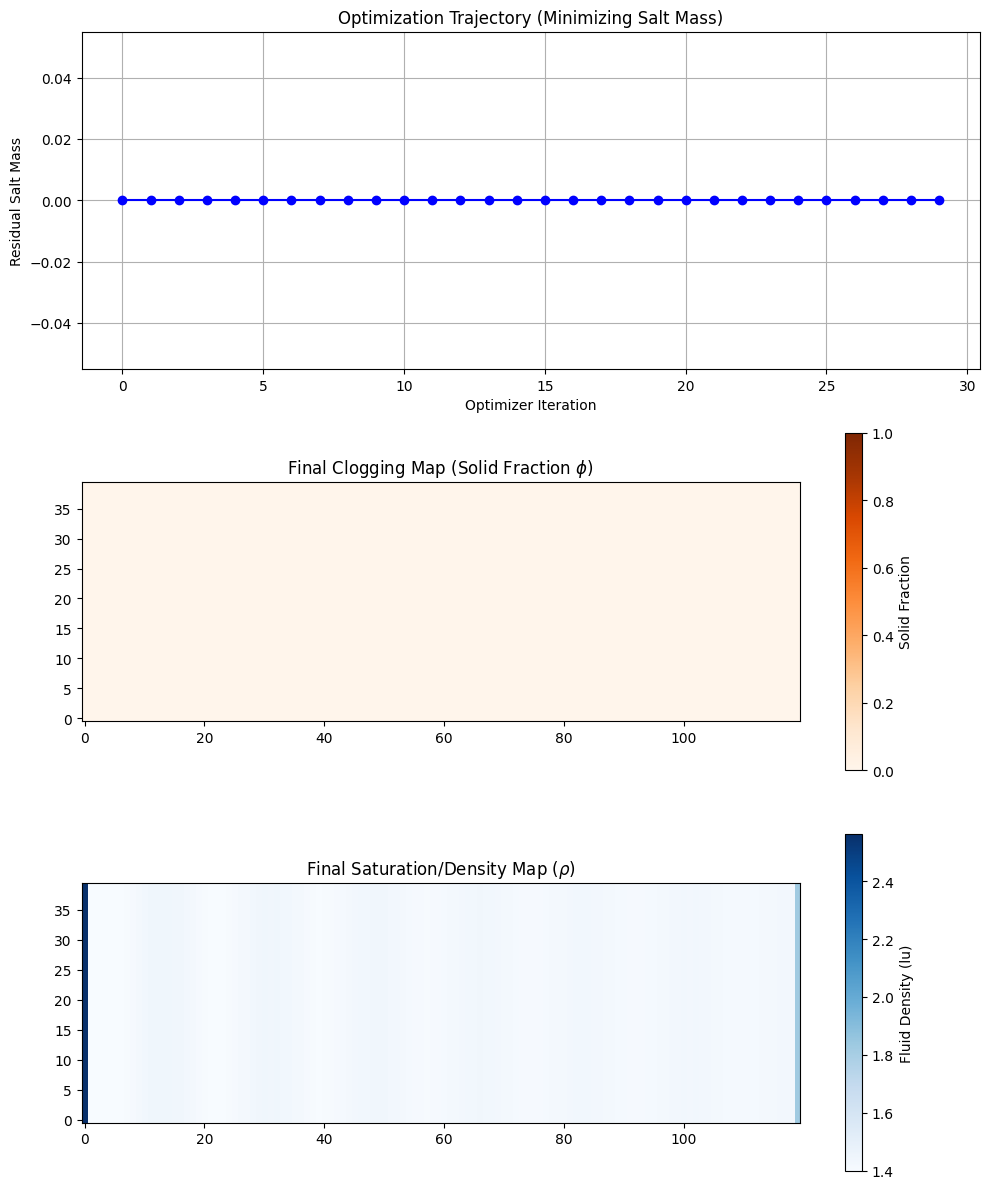

In [12]:
def render_final_state(opt_params):
    # Initialize State
    rho_init = jnp.ones((NX, NY))
    u_init = jnp.zeros((NX, NY, 2))
    state = (equilibrium(rho_init, u_init), equilibrium(jnp.zeros((NX, NY)), u_init), jnp.zeros((NX, NY)))
    
    # --- THE FIX: Wrapper Function ---
    t_arr = jnp.arange(MAX_STEPS)
    
    # This wrapper "freezes" opt_params so scan doesn't try to iterate over it
    def scanned_render_fn(state, t):
        return step_physics(state, (t, opt_params))
        
    # Run scan over Time only
    final_state, history_phi = jax.lax.scan(scanned_render_fn, state, t_arr)
    
    f_final, salt_final, phi_final = final_state
    
    # Calculate Saturation (Fluid Density)
    rho_final = jnp.sum(f_final, axis=-1)
    
    return phi_final, rho_final

# Get Maps with the Best Parameters
print(f"Rendering maps with: {best_params}")
phi_map, rho_map = render_final_state(best_params)

# --- PLOTTING ---
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# 1. Optimization Curve
ax[0].plot(loss_history, 'b-o')
ax[0].set_title("Optimization Trajectory (Minimizing Salt Mass)")
ax[0].set_ylabel("Residual Salt Mass")
ax[0].set_xlabel("Optimizer Iteration")
ax[0].grid(True)

# 2. Clogging Map (Solid Fraction)
# Using raw string r"..." to fix the \phi warning
im1 = ax[1].imshow(phi_map.T, cmap='Oranges', origin='lower', vmin=0, vmax=1)
ax[1].set_title(r"Final Clogging Map (Solid Fraction $\phi$)")
plt.colorbar(im1, ax=ax[1], label="Solid Fraction")

# 3. Saturation Map (Fluid Density)
im2 = ax[2].imshow(rho_map.T, cmap='Blues', origin='lower')
ax[2].set_title(r"Final Saturation/Density Map ($\rho$)")
plt.colorbar(im2, ax=ax[2], label="Fluid Density (lu)")

plt.tight_layout()
plt.show()